# Sentiment Analysis using Tweets (Ukraine and Russia conflict) on Oil Price

#### Twitter API Setup
[Setting up of Code and Cleaning up tweets](https://medium.com/swlh/using-twitter-api-for-tweets-sentiment-analysis-590c97ce52d8)

In [63]:
import matplotlib.pyplot as plt 
%matplotlib inline 
import re 
import pandas as pd 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 
import csv 
import string 
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud,STOPWORDS 
from nltk.stem.porter import PorterStemmer
import requests 
import json 


#### Establish Connection with the Project Dashboard (Twitter Developer API)

In [64]:
nltk.download('stopwords')
n_words = set(stopwords.words('english')) # stop words list 
porter = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhuwa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## References 

[Twitter Client Documentation V2 Endpoints (Tweepy Library)](https://docs.tweepy.org/en/stable/client.html)

### Set Up

In [80]:
# Connect to the API using the Keys 
# use the following function: 
# client = connect_client(<inser params>) 
# client.<insert end points used by Twitter V2>
def connect_client(consumer_key, consumer_secret, brearer_token, access_token, access_token_secret):
    client = tweepy.Client( bearer_token=bearer_token, 
                        consumer_key=consumer_key, 
                        consumer_secret=consumer_secret, 
                        access_token=access_token, 
                        access_token_secret=access_token_secret, 
                        return_type = requests.Response,
                        wait_on_rate_limit=True)
    return client
    
    
# Obtain recent most tweets 
# Params: query and client 
# Output: Dataframe of tweets 
def get_recent_tweets(query, client):
    tweets = client.search_recent_tweets(query = query, tweet_fields = ['author_id', 'created_at'], max_results=100) 
    
    tweets_dict = tweets.json()
    
    return pd.json_normalize(tweets_dict['data'])
    


,text,created_at,author_id,id,withheld.copyright,withheld.country_codes
0,RT @TheAfricaReport: “With the world more depe...,2022-04-09T03:15:26.000Z,37896363,1512630238727094274,NaN,NaN
1,GERMAN ECONOMY MINISTER HABECK SAYS 50% OF OUR...,2022-04-09T03:15:19.000Z,1225793633342935043,1512630206112038913,NaN,NaN
2,"RT @KS_1013: 「since the invasion, the bloc’s 2...",2022-04-09T03:15:16.000Z,25622356,1512630197228433411,NaN,NaN
3,@Mawunya_ @KyivIndependent Sinking of a ship i...,2022-04-09T03:15:02.000Z,1425043804625661952,1512630137615163393,NaN,NaN
4,RT @TheAfricaReport: “With the world more depe...,2022-04-09T03:15:01.000Z,18017198,1512630131969384455,NaN,NaN
...,...,...,...,...,...,...
95,@Reuters Why do you act like this is a garden ...,2022-04-09T03:00:46.000Z,824020728613720064,1512626547626106885,NaN,NaN
96,RT @JoostBroekers: Is the US Govt slapping Eur...,2022-04-09T03:00:45.000Z,1502468948666822657,1512626542676951044,NaN,NaN
97,"RT @edwardfishman: This week, @POTUS imposed t...",2022-04-09T03:00:45.000Z,78527851,1512626540684619777,NaN,NaN
98,@RepMTG Is it true you just voted to keep impo...,2022-04-09T03:00:36.000Z,1261781928702808067,1512626505414844428,NaN,NaN


In [81]:

client = connect_client(consumer_key, consumer_secret, bearer_token, access_token, access_token_secret)

query = "Russia Oil"
tweets = get_recent_tweets(query, client) 

,author_id,text,created_at,id,withheld.copyright,withheld.country_codes
0,441389311,The increased cost of everyday goods and servi...,2022-04-09T03:15:39.000Z,1512630289633320960,NaN,NaN
1,706357166,"RT @ChrisJZullo: Russia, COVID are to blame fo...",2022-04-09T03:15:36.000Z,1512630279709495301,NaN,NaN
2,123041474,What Congress’s sanctions on Russia would do h...,2022-04-09T03:15:32.000Z,1512630262907092992,NaN,NaN
3,37896363,RT @TheAfricaReport: “With the world more depe...,2022-04-09T03:15:26.000Z,1512630238727094274,NaN,NaN
4,1225793633342935043,GERMAN ECONOMY MINISTER HABECK SAYS 50% OF OUR...,2022-04-09T03:15:19.000Z,1512630206112038913,NaN,NaN
...,...,...,...,...,...,...
95,1484373406749319168,The issue between Russia and Ukraine prompted ...,2022-04-09T03:01:03.000Z,1512626618753335301,NaN,NaN
96,137613839,RT @nishkumar1977: India's godowns are brimmin...,2022-04-09T03:00:57.000Z,1512626590634586112,NaN,NaN
97,2949867604,@SaklesSaso Senior U.S. officials flew to Vene...,2022-04-09T03:00:54.000Z,1512626579633053701,NaN,NaN
98,824020728613720064,@Reuters Why do you act like this is a garden ...,2022-04-09T03:00:46.000Z,1512626547626106885,NaN,NaN


In [84]:
tweets['created_at'] = pd.to_datetime(tweets['created_at'])

#### Preprocessing of Text

In [85]:
tweets['created_at']

0    2022-04-09 03:15:39+00:00
1    2022-04-09 03:15:36+00:00
2    2022-04-09 03:15:32+00:00
3    2022-04-09 03:15:26+00:00
4    2022-04-09 03:15:19+00:00
                ...           
95   2022-04-09 03:01:03+00:00
96   2022-04-09 03:00:57+00:00
97   2022-04-09 03:00:54+00:00
98   2022-04-09 03:00:46+00:00
99   2022-04-09 03:00:45+00:00
Name: created_at, Length: 100, dtype: datetime64[ns, UTC]

In [88]:
def clean_up_tweet(tweet):
    # cleaning the tweet from @ tags and links 
    tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) | (\w+:\/\/\S+)", "", tweet).split())
    # converting all letters to lower case and replacing '-' with spaces
    tweet = tweet.lower().replace('-', ' ')
    table = str.maketrans('', '', string.punctuation+string.digits)
    tweet = tweet.translate(table) 
    # tokenising words
    tokens = word_tokenize(tweet) 
    stemmed = [porter.stem(word) for word in tokens]
    words = [w for w in stemmed if not w in n_words]
    
    tweet = ' '.join(words)
    return tweet


import nltk
nltk.download('punkt')

tweets['text'] = tweets['text'].apply(lambda x: clean_up_tweet(x))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bhuwa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [113]:
tweets_df = (tweets['text'])

#### Analysing Sentiment 

analysis = TextBlob(tweet) 
senti = analysis.sentiment.polarity

if senti < 0: 
    emotion = "NEG"
elif senti > 0: 
    emotion = "POS" 
else: 
    emotion = "NEU"

In [119]:
def get_tweets(tweets_df): 
    tweets = [] 
    try: 
        for tweet in tweets_df.iteritems():
            analysis = TextBlob(str(tweet))
            senti= analysis.sentiment.polarity
            # labeling the sentiment
            if senti < 0 :
                emotion = "NEG"
            elif senti > 0 :
                emotion= "POS"
            else:
                emotion= "NEU"
            # appending all data
            tweets.append((tweet, senti, emotion))
        return tweets
    except tweepy.TweepyException as e: 
        print("Error : " + str(e))

In [121]:
# Get sentiment 
sentiment_table = get_tweets(tweets_df)

In [124]:
sentiment_df = pd.DataFrame(sentiment_table, columns=['tweet', 'senti', 'emotion'])

In [127]:
sentiment_df['emotion'].value_counts()

NEU    75
POS    17
NEG     8
Name: emotion, dtype: int64

In [135]:
file_path = '09_04_2022_Ukraine Russia Oil.json'
with open(file_path, encoding='utf8') as f:
    data = json.loads(f.read())

ukraine_russia_oil = pd.json_normalize(data['data'])

In [139]:
ukraine_russia_oil_sentiment = get_tweets(ukraine_russia_oil['text'])

In [142]:
ukraine_russia_oil_sentiment_table = pd.DataFrame(ukraine_russia_oil_sentiment, columns=['tweet', 'senti', 'emotion'])

In [148]:
ukraine_russia_oil_sentiment_table['emotion'].value_counts()

NEU    81
POS    13
NEG     6
Name: emotion, dtype: int64

In [154]:
bar_plot = ukraine_russia_oil_sentiment_table['emotion'].value_counts()

<BarContainer object of 3 artists>

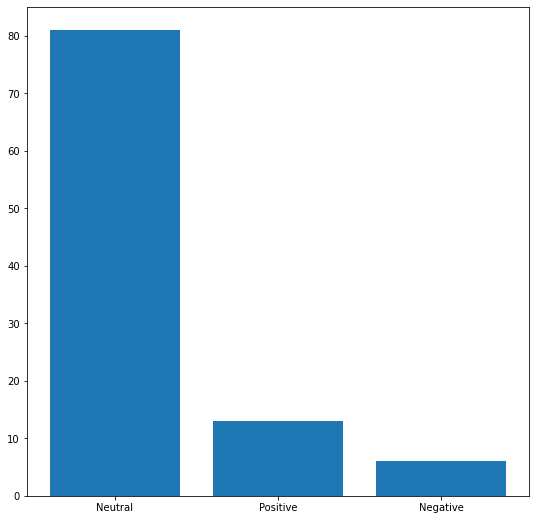

In [159]:
plot_values = {'Neutral': 81, 'Positive': 13, 'Negative' : 6}
values = list(plot_values.values())
names = list(plot_values.keys())

fig, axs = plt.subplots(figsize=(9, 9), sharey=True)
axs.bar(names, values)